<a href="https://colab.research.google.com/github/Megeeee/Machine-Learning/blob/main/UNet_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch.optim as optim

In [2]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode


input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


target_transform = transforms.Compose([

    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])


trainset = datasets.OxfordIIITPet(
    root="~/.pytorch/Pet_data/",
    split="trainval",
    target_types='segmentation',
    download=True,
    transform=input_transform,
    target_transform=target_transform
)

testset = datasets.OxfordIIITPet(
    root="~/.pytorch/Pet_data/",
    split="test",
    target_types='segmentation',
    download=True,
    transform=input_transform,
    target_transform=target_transform
)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

print("Download and Setup Successful!")

Download and Setup Successful!


In [8]:
class UNet(nn.Module):
  def __init__(self,classNum):
    super().__init__()
    #encoder
    self.Conv11 = nn.Conv2d(3,64,kernel_size=3,padding=1)
    self.Conv12 = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.pool1 = nn.MaxPool2d(2,2)

    self.Conv21 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.Conv22 = nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool2 = nn.MaxPool2d(2,2)

    self.Conv31 = nn.Conv2d(128,256,kernel_size=3,padding=1)
    self.Conv32 = nn.Conv2d(256,256,kernel_size=3,padding=1)
    self.pool3 = nn.MaxPool2d(2,2)

    self.Conv41 = nn.Conv2d(256,512,kernel_size=3,padding=1)
    self.Conv42 = nn.Conv2d(512,512,kernel_size=3,padding=1)
    self.pool4 = nn.MaxPool2d(2,2)

    #bn
    self.Convb1 = nn.Conv2d(512,1024,kernel_size=3,padding=1)
    self.Convb2 = nn.Conv2d(1024,1024,kernel_size=3,padding=1)

    #decoder
    self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
    self.Conv51 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
    self.Conv52 = nn.Conv2d(512,512,kernel_size=3,padding=1)

    self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
    self.Conv61 = nn.Conv2d(512,256,kernel_size=3,padding=1)
    self.Conv62 = nn.Conv2d(256,256,kernel_size=3,padding=1)

    self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
    self.Conv71 = nn.Conv2d(256,128,kernel_size=3,padding=1)
    self.Conv72 = nn.Conv2d(128,128,kernel_size=3,padding=1)

    self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    self.Conv81 = nn.Conv2d(128,64,kernel_size=3,padding=1)
    self.Conv82 = nn.Conv2d(64,64,kernel_size=3,padding=1)

    #out
    self.outL = nn.Conv2d(64,classNum, kernel_size=1)



  def forward(self,x):
    d1= F.relu(self.Conv12(F.relu(self.Conv11(x))))
    d1p = self.pool1(d1)

    d2= F.relu(self.Conv22(F.relu(self.Conv21(d1p))))
    d2p = self.pool2(d2)

    d3= F.relu(self.Conv32(F.relu(self.Conv31(d2p))))
    d3p = self.pool3(d3)

    d4= F.relu(self.Conv42(F.relu(self.Conv41(d3p))))
    d4p = self.pool4(d4)

    bn = F.relu(self.Convb2(F.relu(self.Convb1(d4p))))

    u1 = torch.cat([self.upconv1(bn),d4],dim=1)
    u1 = F.relu(self.Conv52(F.relu(self.Conv51(u1))))

    u2 = torch.cat([self.upconv2(u1),d3],dim=1)
    u2 = F.relu(self.Conv62(F.relu(self.Conv61(u2))))

    u3 = torch.cat([self.upconv3(u2),d2],dim=1)
    u3 = F.relu(self.Conv72(F.relu(self.Conv71(u3))))

    u4 = torch.cat([self.upconv4(u3),d1],dim=1)
    u4 = F.relu(self.Conv82(F.relu(self.Conv81(u4))))

    return(self.outL(u4))

model = UNet(3).to('cuda')
summary(model, (1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 256, 256]          --
├─Conv2d: 1-1                            [1, 64, 256, 256]         1,792
├─Conv2d: 1-2                            [1, 64, 256, 256]         36,928
├─MaxPool2d: 1-3                         [1, 64, 128, 128]         --
├─Conv2d: 1-4                            [1, 128, 128, 128]        73,856
├─Conv2d: 1-5                            [1, 128, 128, 128]        147,584
├─MaxPool2d: 1-6                         [1, 128, 64, 64]          --
├─Conv2d: 1-7                            [1, 256, 64, 64]          295,168
├─Conv2d: 1-8                            [1, 256, 64, 64]          590,080
├─MaxPool2d: 1-9                         [1, 256, 32, 32]          --
├─Conv2d: 1-10                           [1, 512, 32, 32]          1,180,160
├─Conv2d: 1-11                           [1, 512, 32, 32]          2,359,808
├─MaxPool2d: 1-12                        [1, 

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Training on:} NVIDIA A100-SXM4-80GB
[Epoch: 1, Batch: 20] loss: 0.190
[Epoch: 1, Batch: 40] loss: 0.183
[Epoch: 1, Batch: 60] loss: 0.180
[Epoch: 1, Batch: 80] loss: 0.209
[Epoch: 1, Batch: 100] loss: 0.202
[Epoch: 1, Batch: 120] loss: 0.216
[Epoch: 1, Batch: 140] loss: 0.213
[Epoch: 1, Batch: 160] loss: 0.211
[Epoch: 1, Batch: 180] loss: 0.214
[Epoch: 1, Batch: 200] loss: 0.205
[Epoch: 1, Batch: 220] loss: 0.204
[Epoch: 2, Batch: 20] loss: 0.188
[Epoch: 2, Batch: 40] loss: 0.189
[Epoch: 2, Batch: 60] loss: 0.188
[Epoch: 2, Batch: 80] loss: 0.187
[Epoch: 2, Batch: 100] loss: 0.185
[Epoch: 2, Batch: 120] loss: 0.183
[Epoch: 2, Batch: 140] loss: 0.184
[Epoch: 2, Batch: 160] loss: 0.180
[Epoch: 2, Batch: 180] loss: 0.190
[Epoch: 2, Batch: 200] loss: 0.191
[Epoch: 2, Batch: 220] loss: 0.197
[Epoch: 3, Batch: 20] loss: 0.180
[Epoch: 3, Batch: 40] loss: 0.175
[Epoch: 3, Batch: 60] loss: 0.174
[Epoch: 3, Batch: 80] loss: 0.173
[Epoch: 3, Batch: 100] loss: 0.185
[Epoch: 3, Batch: 120] loss: 0.

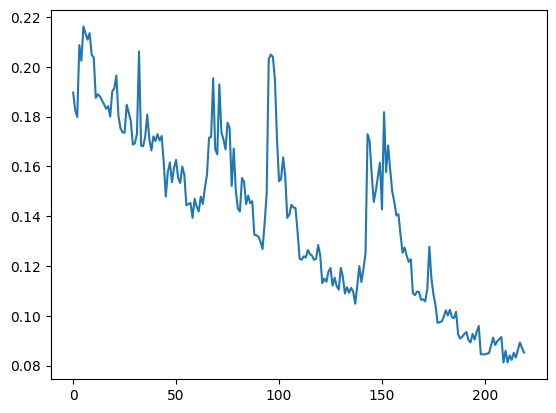

Finished Training


In [19]:
#train
print("Training on:}",torch.cuda.get_device_name(0))

lossL = []

for epoch in range(20):
  runningLoss =0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs = inputs.to("cuda")
    labels = labels.to("cuda")

    labels = labels.squeeze(1)

    labels = labels.long() - 1

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    runningLoss += loss.item()
    loss.backward()
    optimizer.step()
    if i % 20 == 19:
            print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] loss: {runningLoss / 20:.3f}')
            lossL.append(runningLoss/20)
            runningLoss = 0.0

plt.plot(lossL)
plt.show()
print('Finished Training')

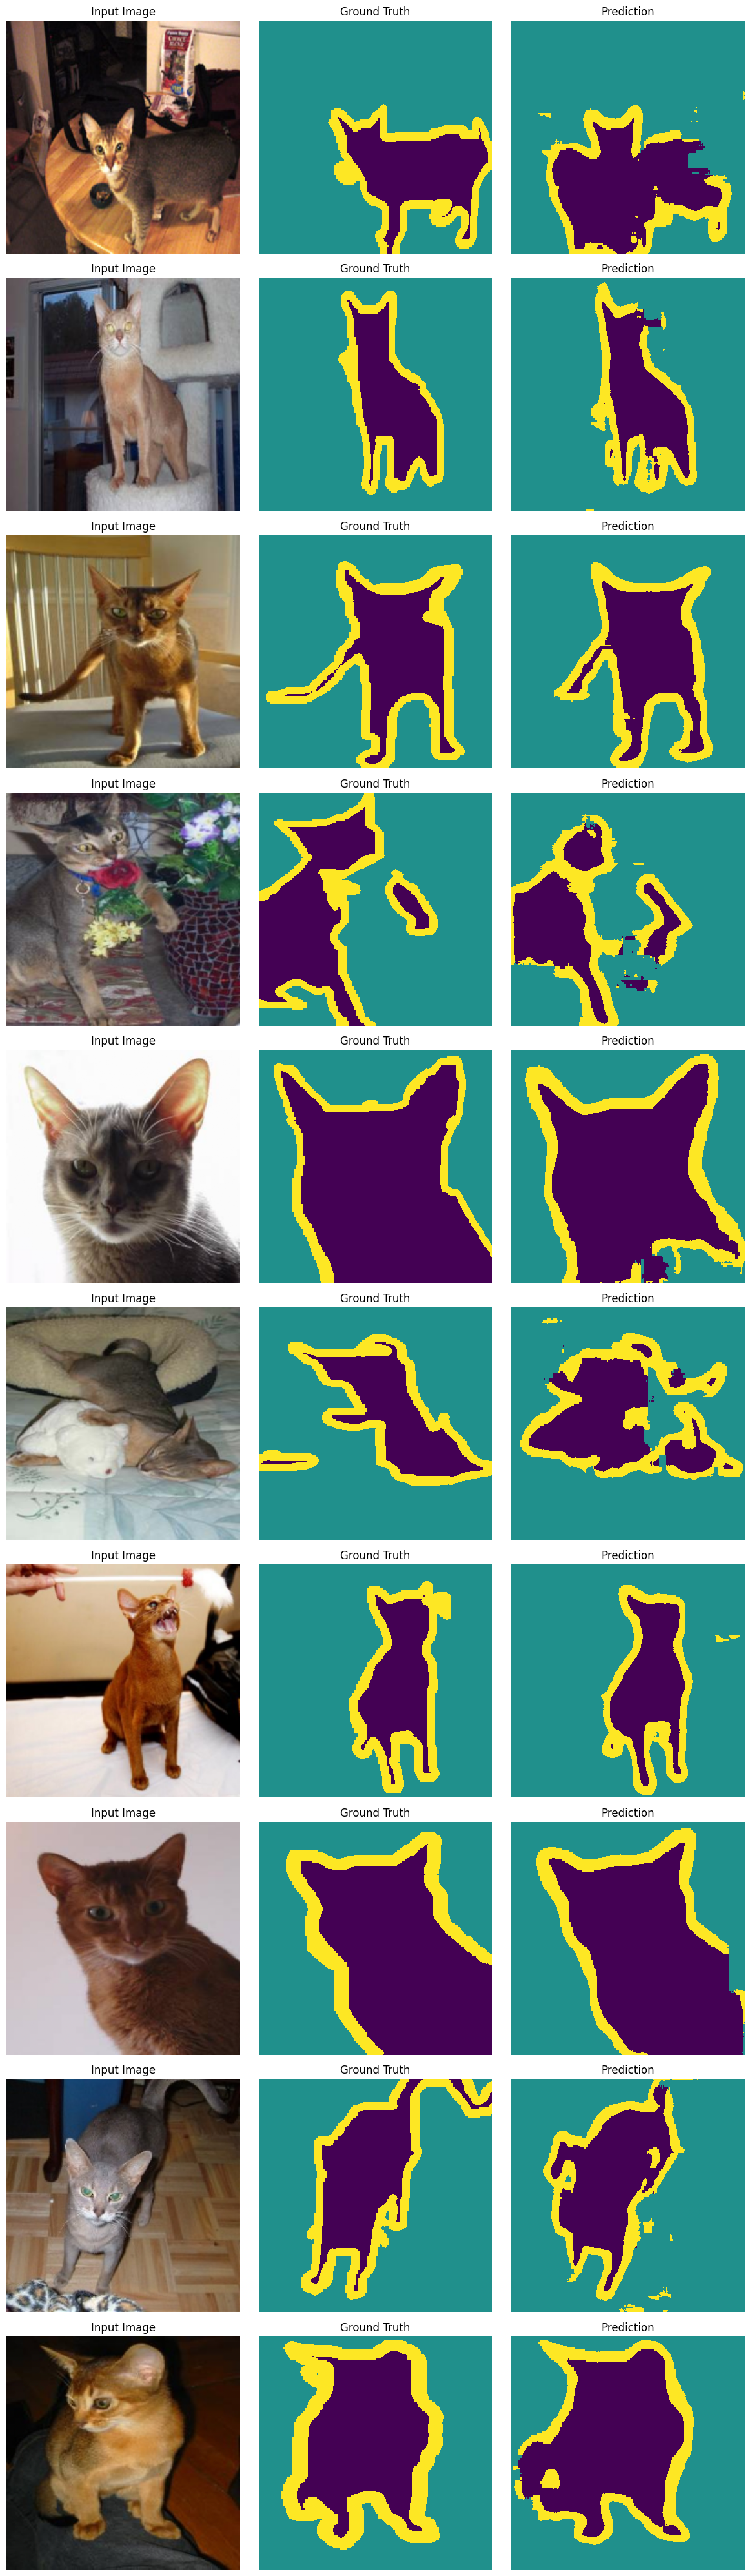

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_preds(model, loader, device='cuda', num_samples=3):
    model.eval() # Set to evaluation mode

    # 1. Get a batch of data
    data_iter = iter(loader)
    images, masks = next(data_iter)

    images = images.to(device)

    # 2. Run Inference
    with torch.no_grad():
        outputs = model(images)
        # Convert logits (3 channels) -> Class Index (0, 1, or 2)
        preds = torch.argmax(outputs, dim=1)

    # 3. Setup the plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    # Handle case if num_samples is 1 (axes is 1D array)
    if num_samples == 1: axes = [axes]

    for i in range(num_samples):
        # --- A. Prepare Image ---
        # Move to CPU -> Permute to (H, W, C) for Matplotlib
        img = images[i].cpu().permute(1, 2, 0).numpy()

        # --- B. Prepare True Mask ---
        # Squeeze the channel dim: [1, H, W] -> [H, W]
        # Shift values: 1,2,3 -> 0,1,2 to match prediction
        true_mask = masks[i].cpu().squeeze().numpy() - 1

        # --- C. Prepare Predicted Mask ---
        pred_mask = preds[i].cpu().numpy()

        # --- Plotting ---
        # Column 1: Input Image
        axes[i][0].imshow(img)
        axes[i][0].set_title("Input Image")
        axes[i][0].axis('off')

        # Column 2: Ground Truth
        # vmin=0, vmax=2 ensures colors map consistently (0=Bg, 1=Pet, 2=Border)
        axes[i][1].imshow(true_mask, cmap='viridis', interpolation='nearest', vmin=0, vmax=2)
        axes[i][1].set_title("Ground Truth")
        axes[i][1].axis('off')

        # Column 3: Prediction
        axes[i][2].imshow(pred_mask, cmap='viridis', interpolation='nearest', vmin=0, vmax=2)
        axes[i][2].set_title("Prediction")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Call the function ---
# Pass your model and the TEST loader
visualize_test_preds(model, testloader, num_samples=10)